In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix

In [ ]:
def load_and_preprocess_data(file_path, time_range):
    # Load the MATLAB file
    data = loadmat(file_path)

    # Extract EEG data and transpose it (trials as rows, time points as columns)
    eeg_data = data['all_epochs'].T

    # Extract time stamps
    time_stamps = data['t'][0, :]

    # Extract class labels
    labels = data['clss'][:, 0]

    # Create a boolean mask for the specified time range
    time_mask = (time_stamps >= time_range[0]) & (time_stamps <= time_range[1])

    # Return filtered EEG data, corresponding time stamps, and labels
    return eeg_data[:, time_mask], time_stamps[time_mask], labels

In [ ]:
def visualize_eeg(time, signal, title):
    # Create a new figure with specified size
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the EEG signal
    ax.plot(time, signal)

    # Set the title and labels for the plot
    ax.set_title(title)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Signal Amplitude')

    # Add a grid to the plot for better readability
    ax.grid(True)

    # Display the plot
    plt.show()

def recode_labels(original_labels):
    # Define groups of labels to be combined
    label_groups = {
        0: [1, 5, 9, 13],  # Male voice 1
        1: [2, 6, 10, 14], # Male voice 2
        2: [3, 7, 11, 15], # Female voice 1
        3: [4, 8, 12, 16]  # Female voice 2
    }

    # Create a new array to store recoded labels
    new_labels = np.zeros_like(original_labels)

    # Recode labels based on the defined groups
    for new_label, old_labels in label_groups.items():
        new_labels[np.isin(original_labels, old_labels)] = new_label

    return new_labels

def custom_classification_report(y_true, y_pred, labels=None):
    # Calculate precision, recall, F1-score, and support for each class
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=labels)

    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Create header for the report
    header = f"{'Class':^10}{'Precision':^12}{'Recall':^12}{'F1-score':^12}{'Support':^12}"
    separator = "-" * 58

    # Create rows for each class
    rows = []
    for i, label in enumerate(labels):
        row = f"{label:^10}{precision[i]:^12.2f}{recall[i]:^12.2f}{f1[i]:^12.2f}{support[i]:^12d}"
        rows.append(row)

    # Create accuracy row
    accuracy_row = f"{'Accuracy':^10}{accuracy:^12.2f}"

    # Combine all parts of the report
    report = "\n".join([header, separator] + rows + [separator, accuracy_row])
    return report

def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the confusion matrix as an image
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Add colorbar
    ax.figure.colorbar(im, ax=ax)

    # Set up the axes
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Adjust the layout and display the plot
    fig.tight_layout()
    plt.show()

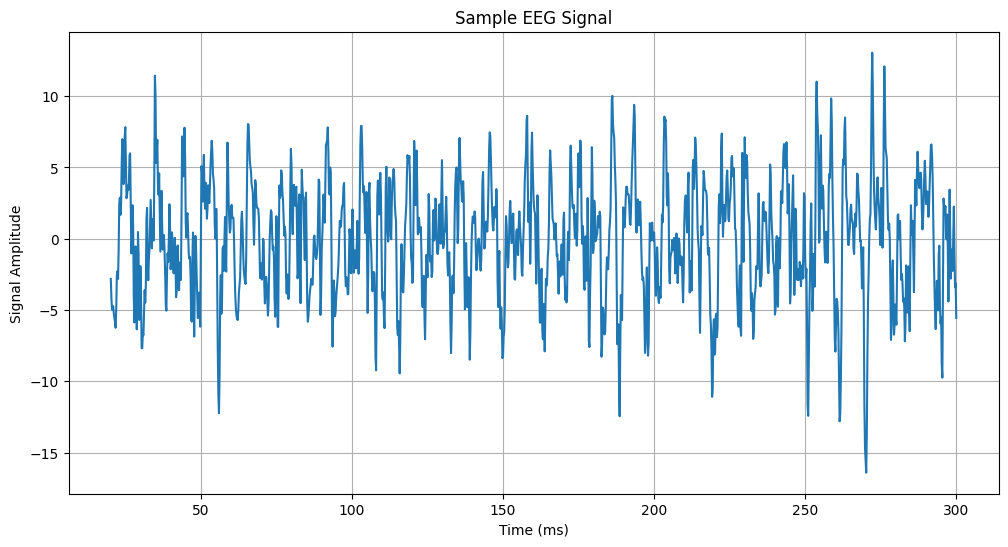

Total number of samples: 5522
Number of training samples: 4417
Number of test samples: 1105
Custom Classification Report:
  Class    Precision     Recall     F1-score    Support   
----------------------------------------------------------
    0         0.35        0.27        0.31        310     
    1         0.52        0.51        0.52        269     
    2         0.29        0.37        0.32        253     
    3         0.36        0.36        0.36        273     
----------------------------------------------------------
 Accuracy     0.37    


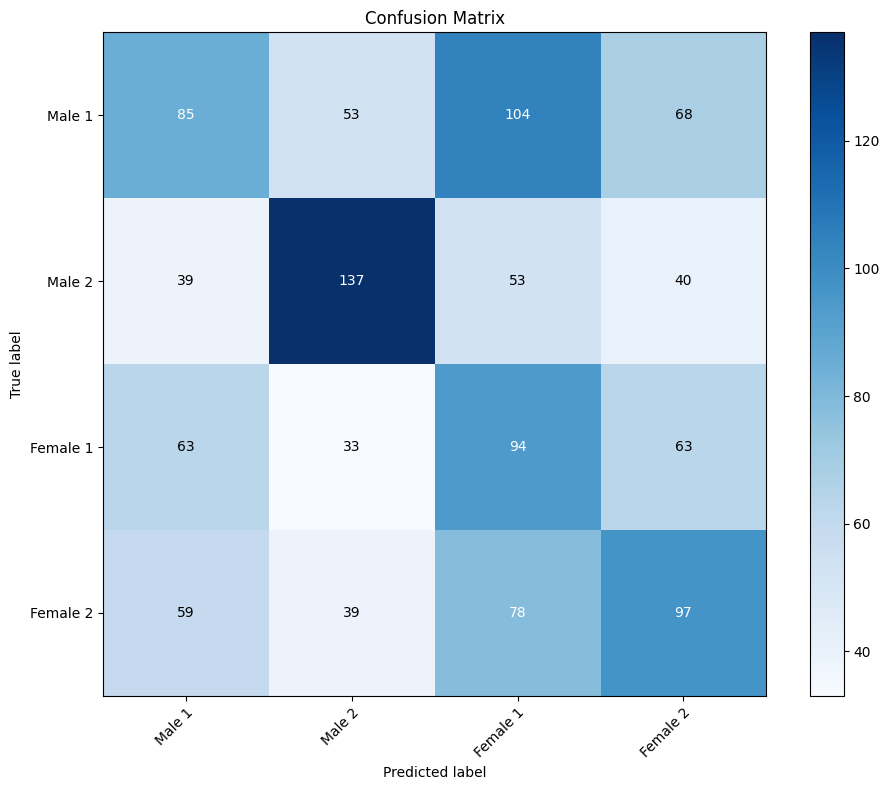

In [ ]:
def main():
    # Load and preprocess the EEG data
    eeg_signals, time, class_labels = load_and_preprocess_data('./subj_014.mat', (20, 300))

    # Visualize a sample EEG signal (the 11th trial in this case)
    visualize_eeg(time, eeg_signals[10, :], 'Sample EEG Signal')

    # Recode the original 16 classes into 4 classes
    recoded_labels = recode_labels(class_labels)

    # Split the data into training (80%) and test (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(
        eeg_signals, recoded_labels, test_size=0.2, random_state=42
    )

    # Create and train the Random Forest classifier
    forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
    forest_model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = forest_model.predict(X_test)

    # Print dataset size information
    print(f"Total number of samples: {len(eeg_signals)}")
    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of test samples: {len(X_test)}")

    # Print the custom classification report
    print("Custom Classification Report:")
    print(custom_classification_report(y_test, predictions, labels=[0, 1, 2, 3]))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, predictions, classes=['Male 1', 'Male 2', 'Female 1', 'Female 2'])

# Check if this script is being run directly (not imported)
if __name__ == "__main__":
    main()  # If so, execute the main function